## Document Similarity

use Cosine similarity

In [16]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1)) * np.sqrt(sum(np.square(v2)))))
    similarity = dot_product / l2_norm

    return similarity

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ["if you take the blue pill, the story ends",
            "if you take the red pill, you stay in Wonderland",
            "if you take the red pill, I show you how deep the rabbit hole goes"]

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [13]:
print(feature_vect_simple[0])

  (0, 2)	0.41556360057939173
  (0, 13)	0.41556360057939173
  (0, 8)	0.24543855687841593
  (0, 0)	0.41556360057939173
  (0, 15)	0.49087711375683185
  (0, 14)	0.24543855687841593
  (0, 17)	0.24543855687841593
  (0, 6)	0.24543855687841593


In [17]:
feature_vect_dense = feature_vect_simple.todense()

vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )

similarity_simple = cos_similarity(vect1, vect2)
print("similarity: {0:.3f}".format(similarity_simple))

similarity: 0.402


In [18]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )

similarity_simple = cos_similarity(vect1, vect3)
print("similarity: {0:.3f}".format(similarity_simple))


vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )

similarity_simple = cos_similarity(vect2, vect3)
print("similarity: {0:.3f}".format(similarity_simple))

similarity: 0.404
similarity: 0.456


In [19]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [21]:
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print("shape:", similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


In [22]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환.
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거-> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환.
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [23]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 700)

path = r"/Users/jinjae/Code/Study/Python-Machine-Learning/OpinosisDataset1.0/topics"
# all .data files to a list
all_files = glob.glob(os.path.join(path, "*.data"))
filename_list = []
opinion_text = []

# load with DataFrame and convert to string, merge to opinion_text list
for file_ in all_files:
    # to DataFrame
    df = pd.read_table(file_, index_col=None, header=0, encoding="latin1")

    filename_ = file_.split('/')[-1]
    filename = filename_.split('.')[0]

    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({"filename": filename_list, "opinion_text": opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words="english",
                             ngram_range=(1, 2), min_df=0.05, max_df=0.85)

feature_vect = tfidf_vect.fit_transform(document_df["opinion_text"])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df["cluster_label"] = cluster_label

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

hotel_indexes = document_df[document_df["cluster_label"] == 2].index
print("Dataframe Index:", hotel_indexes)

Dataframe Index: Int64Index([2, 3, 4, 13, 16, 17, 20, 27, 28, 30, 31, 32, 39, 46, 49, 50], dtype='int64')


In [25]:
comparison_docname = document_df.iloc[hotel_indexes[0]]["filename"]
print("###", comparison_docname, "and other document similarities")

similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

### room_holiday_inn_london and other document similarities
[[1.         0.19917258 0.22235374 0.37631406 0.26026786 0.15836737
  0.19544761 0.40020673 0.31124876 0.77312013 0.51442299 0.15026112
  0.16717527 0.81484367 0.11154184 0.10831277]]


most similarity filename and similarity:
 filename      rooms_bestwestern_hotel_sfo
similarity                       0.814844
Name: 46, dtype: object


Text(0.5, 1.0, 'room_holiday_inn_london')

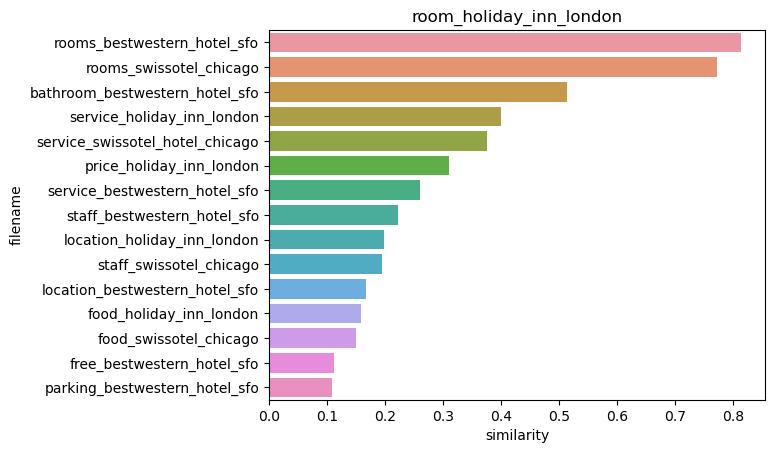

In [27]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# resort
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# visualize
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

print("most similarity filename and similarity:\n", hotel_1_sim_df.iloc[0, :])
sns.barplot(x='similarity', y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)